In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score

# For saving img
from os.path import join, basename, exists
from os import getcwd
dir_name = basename(getcwd())
img_dir = join(getcwd(), "images")
if not exists(img_dir):
    os.mkdir(img_dir)

In [2]:
import glob
from config import *
bkg_files = glob.glob(join(raw_data_path, "bkg.*"))
signal_files = list(set(glob.glob(join(raw_data_path, "*.*"))) - set(bkg_files))
all_files = bkg_files + signal_files

print("Signal files:", len(signal_files), "\nBackground files:", len(bkg_files), "\n> Total:", len(all_files))

Signal files: 7 
Background files: 1 
> Total: 8


In [3]:
from os.path import basename
all_data = []

for path in all_files:
    data = pd.read_hdf(path, index_col=0)

    data['name'] = basename(path).replace(".h5", "")
    all_data.append(data)

data = pd.concat(all_data)
del all_data
data = data[['name', 'ScalarHT_HT', 'gen_xsec']]

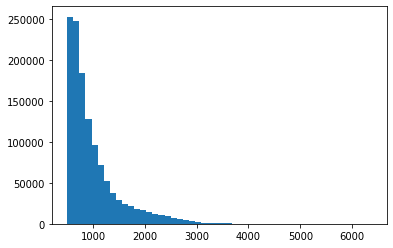

In [4]:
plt.hist(data['ScalarHT_HT'], bins=50)
plt.show()

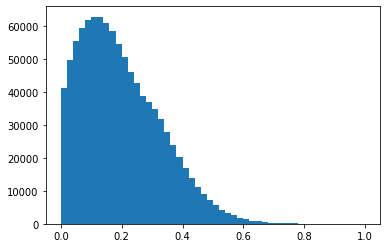

In [5]:
to_plot = np.log(data[data['name'] == 'bkg']['ScalarHT_HT'] + np.finfo(float).eps)
to_plot = to_plot - to_plot.min()
to_plot = to_plot / to_plot.max()
plt.hist(to_plot, bins=50)
plt.show()

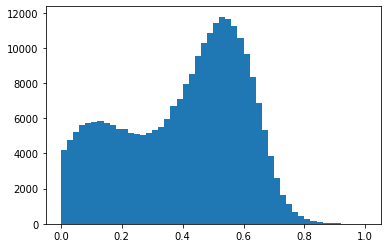

In [6]:
to_plot = np.log(data[data['name'] != 'bkg']['ScalarHT_HT'] + np.finfo(float).eps)
to_plot = to_plot - to_plot.min()
to_plot = to_plot / to_plot.max()
plt.hist(to_plot, bins=50)
plt.show()

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

bins = 50

# Plot creation
features = list(data['name'].unique())

distributions = {}

for x in tqdm(features, total=len(features), desc="Processing..."):

    ## Get the relevant data
    sData = data.loc[data['name'] == x].drop(columns=['name'])
    sData = sData['ScalarHT_HT']
    sData = sData.to_numpy(dtype=np.float32)

    sData = np.log(sData + np.finfo(float).eps)
    # Append to list
    distributions[x] = sData

In [8]:
## Normalize the distributions
# This way all values should be between 0 and 1

# x transform
min_of_dist = min(map(lambda x: min(x), distributions.values()))
for x in distributions:
    distributions[x] = distributions[x] - min_of_dist
# scale
max_of_dist = max(map(lambda x: max(x), distributions.values()))
for x in distributions:
    distributions[x] = distributions[x] / max_of_dist

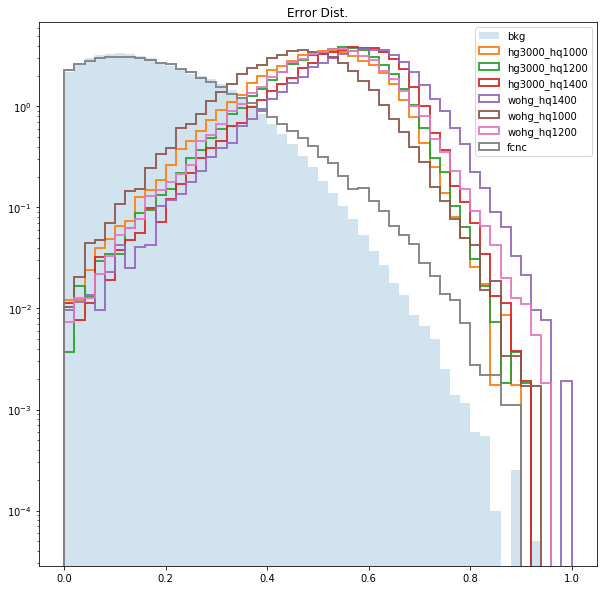

In [9]:
## Plot error distributions
fig, ax = plt.subplots( figsize=(10,10))
ax.set_yscale('log')

for x in tqdm(distributions.keys(), desc="Processing..."):

    hist_range = (0, 1)        

    if x != 'bkg':
        ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
    else:
        ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

ax.autoscale(enable=True) 
ax.set_title("Error Dist.")
ax.legend()
fig.savefig(join(img_dir, dir_name+"_ht_dist.png"), bbox_inches = 'tight')

ROC SCORE for hg3000_hq1000: 0.9832183804441849
Confusion matrix:
[[988919  13571]
 [ 13999  14912]]


ROC SCORE for hg3000_hq1200: 0.987921698337924
Confusion matrix:
[[988919  13571]
 [ 10904  16328]]


ROC SCORE for hg3000_hq1400: 0.9903400901806948
Confusion matrix:
[[988919  13571]
 [  8163  18060]]


ROC SCORE for wohg_hq1400: 0.9920570220103736
Confusion matrix:
[[988919  13571]
 [  6787  19149]]


ROC SCORE for wohg_hq1000: 0.9753717995345685
Confusion matrix:
[[988919  13571]
 [ 18626  10636]]


ROC SCORE for wohg_hq1200: 0.9872660522465447
Confusion matrix:
[[988919  13571]
 [ 11383  15968]]


ROC SCORE for fcnc: 0.6563363772232813
Confusion matrix:
[[988919  13571]
 [ 87705   2843]]





<ipython-input-10-06bc5cdb72b9>:39: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

/home/acujl/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



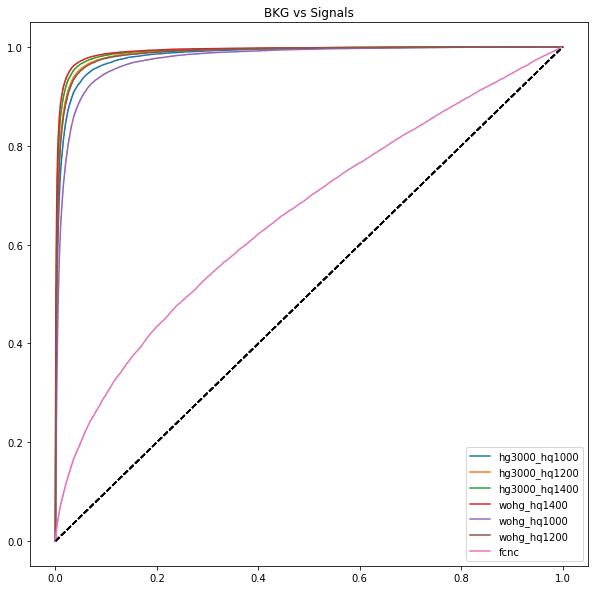

In [10]:

## Plot ROC Curves
fig_roc, ax_roc = plt.subplots(figsize=(10,10))
for x in tqdm(distributions.keys(), desc="Processing..."):
    if x != 'bkg':
        # Set labels
        bkg_labels = np.zeros(distributions['bkg'].shape[0]).astype(int)
        signal_labels = np.ones(distributions[x].shape[0]).astype(int)
        labels = np.concatenate([bkg_labels, signal_labels])

        # Set Scores
        score = np.concatenate([distributions['bkg'], distributions[x]]) 

        # Set weights
        weights = pd.concat([
                            data[data['name'] == "bkg"]['gen_xsec'], 
                            data[data['name'] == x]['gen_xsec']
                            ])

        # Get Curve
        fpr, tpr, thr = roc_curve(
                y_true=labels, 
                y_score=score,
                sample_weight=weights
                )
        
        
        ax_roc.plot(fpr, tpr, label=x)
        ax_roc.plot([0,1],[0,1], 'k--')

        print(f"ROC SCORE for {x}:", 
                roc_auc_score(y_true=labels, 
                y_score=score,
                sample_weight=weights))
        #print(score.min(), score.max())
        #print(np.unique(np.rint(score)))
        print("Confusion matrix:")
        print(confusion_matrix(labels, np.rint(score)))
        print("\n")
fig_roc.show()
ax_roc.set_title(f"BKG vs Signals")
ax_roc.legend()
            

fig.tight_layout()
plt.show()
fig_roc.savefig(join(img_dir, dir_name+"_ht_rocs.png"), bbox_inches = 'tight')